#  Autoencoders notebook

![](https://curiousily.com/static/239315188ad13ab0270f753fd899b536/629d2/autoencoder-architecture.png) [source](https://curiousily.com/static/239315188ad13ab0270f753fd899b536/629d2/autoencoder-architecture.png)

## Demo notebook :

We will test here autoencoders for anomaly detection on ECG5000

In [1]:
%cd ..

/Users/erwan/Programmes/2022 Datacamp/solar_wind


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError


# Fonctions ajoutées
from display import plot_event, multiple_plots, consecutive_plots, display_timeline, show_densities
from problem import get_train_data, get_test_data
from problem import turn_prediction_to_event_list

# visualisation
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib inline

2023-01-22 17:58:37.353350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [138]:
data_train, labels_train = get_train_data()
data_test, labels_test = get_test_data()

calm_train_s = data_train['Beta'][labels_train == 0]
calm_test_s = data_test['Beta'][labels_test == 0]

storm_train_s = data_train['Beta'][labels_train == 1]

On nettoie la base de données
(Le faire avant le découpage ?)

In [139]:
seuil = 50
# scaler = MinMaxScaler()

# DONNÉES D'ENTRAÎNEMENT
calm_train_s = calm_train_s.map(lambda x: min(x, seuil))
calm_train_s = calm_train_s.rolling('50 min', center=True).mean()
# min_max_calm_train_data = scaler.fit_transform(calm_train_s.to_frame())
# calm_data_s = pd.Series(min_max_calm_train_data.flatten())

In [140]:
seuil = 50
# scaler = MinMaxScaler()
storm_train_s = storm_train_s.map(lambda x: min(x, seuil))
storm_train_s = storm_train_s.rolling('50 min', center=True).mean()

# min_max_storm_train_data = scaler.fit_transform(storm_train_s.to_frame())
# storm_data_s = pd.Series(min_max_storm_train_data.flatten())

On découpe la base de données en plusieurs intervalles de temps

In [141]:
def serie_to_sample(data):
    step = 140 # Nombre de mesures par intervalle (environ 23h ici)
    # chevauchement = 10 # 10 mesures soit 1h40

    df = pd.DataFrame({})
    j = 0
    for i in range(0, len(data) - step, step):
        df['inter_' + str(j)] = data.iloc[i:(i + step)].values
        j += 1 

    df = df.T
    return df

In [144]:
data_df = serie_to_sample(calm_train_s)
train_data_df, test_data_df = train_test_split(data_df, test_size=0.2, random_state=0)

In [145]:
train_data_df.shape, test_data_df.shape, type(train_data_df[0])

((2578, 140), (645, 140), pandas.core.series.Series)

In [ ]:
storm_df = serie_to_sample(storm_train_s)
storm_tf = tf.cast(storm_df.to_numpy(), tf.float32)

In [147]:
train_data_tf = tf.cast(train_data_df.to_numpy(), tf.float32)
test_data_tf = tf.cast(test_data_df.to_numpy(), tf.float32)

train_data_tf.shape

TensorShape([2578, 140])

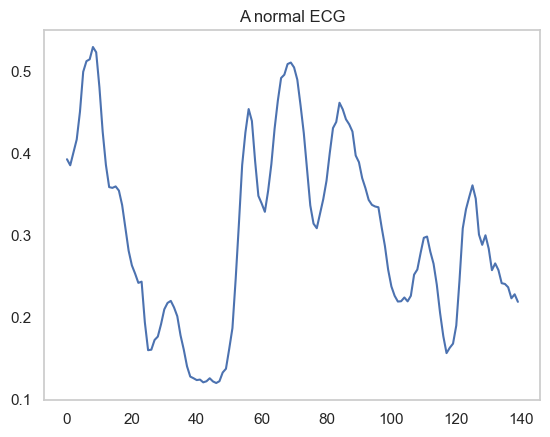

In [150]:
plt.grid()
plt.plot(np.arange(140), train_data_tf[4])
plt.title("A normal ECG")
plt.show()

In [156]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [157]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=optimizer, loss='mae')

Epoch 1/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.3317 - val_loss: 0.3482
Epoch 2/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.3317 - val_loss: 0.3486
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3317 - val_loss: 0.3482
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3315 - val_loss: 0.3479
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3313 - val_loss: 0.3486
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3316 - val_loss: 0.3481
Epoch 7/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3313 - val_loss: 0.3493
Epoch 8/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3320 - val_loss: 0.3481
Epoch 9/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3314 - val_loss: 0.3482
Epoch 10/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3314 - val_loss: 0.3480
Epoch 11/1000
6/6

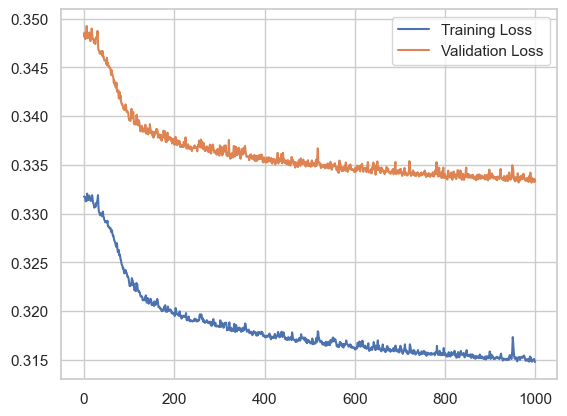

In [163]:
history = autoencoder.fit(train_data_tf, train_data_tf,
epochs=1000,
batch_size=512,
validation_data=(test_data_tf, test_data_tf),
shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Let's see how our autoencoder reconstruct the data when it is normal :

Erreur mae : 0.15727468


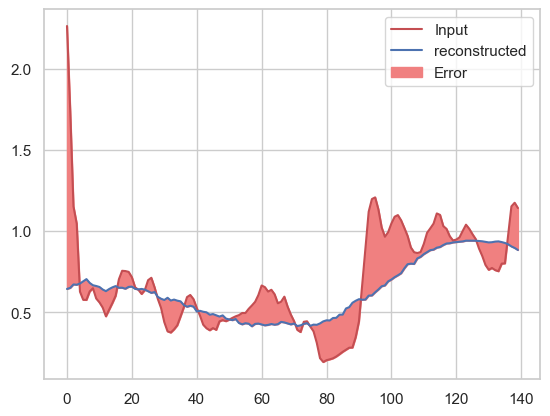

In [166]:
sample_nb = 20
sample = train_data_tf[sample_nb: (sample_nb + 2)]

encoded_sample = autoencoder.encoder(sample).numpy()
decoded_sample = autoencoder.decoder(encoded_sample)[0].numpy()

sample = sample[0]
print('Erreur mae :', tf.keras.losses.mae(sample, decoded_sample).numpy())
plt.plot(sample, 'r')
plt.plot(decoded_sample, 'b')
plt.fill_between(np.arange(140), sample,  decoded_sample, color='lightcoral')
plt.legend(labels=["Input", "reconstructed", 'Error'])
plt.show()

### Let's see now how it does when the data is anormal :

Erreur mae : 0.025950124


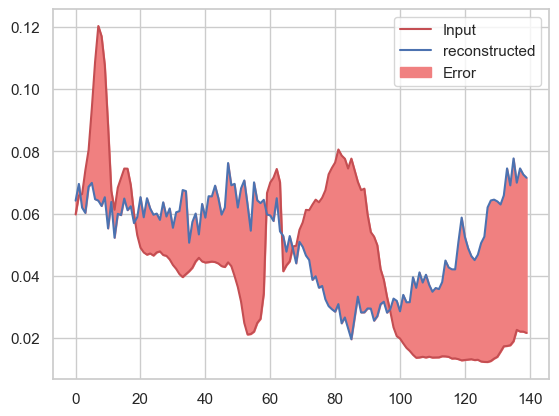

In [167]:
sample_nb = 20
sample = storm_tf[sample_nb: (sample_nb + 2)]

encoded_sample = autoencoder.encoder(sample).numpy()
decoded_sample = autoencoder.decoder(encoded_sample)[0].numpy()

sample = sample[0]
print('Erreur mae :', tf.keras.losses.mae(sample, decoded_sample).numpy())
plt.plot(sample, 'r')
plt.plot(decoded_sample, 'b')
plt.fill_between(np.arange(140), sample,  decoded_sample, color='lightcoral')
plt.legend(labels=["Input", "reconstructed", 'Error'])
plt.show()

## Anomalies detection

So we saw that when the input is an anomaly, the reconstruction error will be greater than normal, let's detect errors when the mae is greater than some threshold

## Attack plan :

First, we need to find the threshold, so let's find the average of the error in the normal dataset

then use this threshold to categorate errors.

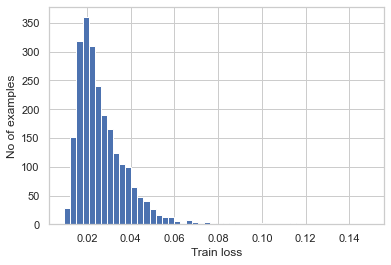

In [ ]:
reconstruction = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_train_data)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# Get the threshold :

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.040307388


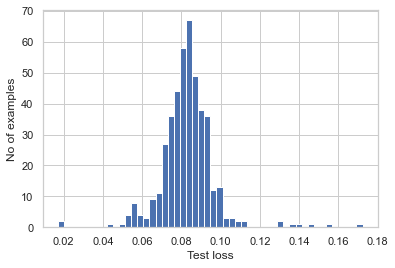

In [ ]:
# Let's plot the error when there is anomalies
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
    """This function, will take the data then get the reconstruction from the model and process the error.
    If it is greater than the threshold ==> this is not normal !    
    """
    reconstruction = model(data)
    loss = tf.keras.losses.mae(reconstruction, data)
    return tf.math.less(loss, threshold)

In [ ]:
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.934
Precision = 0.9959839357429718
Recall = 0.8857142857142857


# Ressources :

## Some links :

[interactive example](https://anomagram.fastforwardlabs.com/#/)
<br />
Real-world use case :
[Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)
<br />
[blog post](https://blog.keras.io/building-autoencoders-in-keras.html)
<br />
More details :
[Deep Learning](https://www.deeplearningbook.org/)